In [8]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [9]:
#load data
train_data = pd.read_csv('train.csv')

In [10]:
train_data.head()

,PatientID,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,761,52,M,ASY,112,230,0,Normal,160,N,0.0,Up,1
1,181,51,M,ATA,130,224,0,Normal,150,N,0.0,Up,0
2,309,57,M,ASY,95,0,1,Normal,182,N,0.7,Down,1
3,84,56,M,ASY,150,213,1,Normal,125,Y,1.0,Flat,1
4,88,43,M,TA,120,291,0,ST,155,N,0.0,Flat,1


In [11]:
test_data = pd.read_csv('test_X.csv')

In [12]:
#extract features
X = train_data.drop(['PatientID', 'HeartDisease'], axis=1)
X_target = test_data.drop('PatientID', axis=1)

# extract labels
y = train_data['HeartDisease']

In [13]:
#replace the 0 in cholestral to the mean value of the rest, how come when you do this the F1 decrease? after trying ways I decide to delete the row that has missing data
#non_zero_mean = X_train[X_train['Cholesterol'] != 0]['Cholesterol'].mean()

#X_train['Cholesterol'] = X_train['Cholesterol'].replace(0, non_zero_mean)
X_train= X_train[X_train['Cholesterol'] != 0]

In [14]:
#split the data into training and test sets (80%training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# Encode categorical features (e.g., Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope)
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoder = LabelEncoder()
for feature in categorical_features:
    X_train[feature] = encoder.fit_transform(X_train[feature])
    X_test[feature] = encoder.transform(X_test[feature])
    X_target[feature]= encoder.transform(X_target[feature])

In [16]:
#feature selection
sel = VarianceThreshold(.8 * (1 - .8))
sel.fit_transform(X_train)

array([[58. ,  1. ,  0. , ...,  0. ,  0. ,  2. ],
       [55. ,  1. ,  1. , ...,  0. ,  0. ,  2. ],
       [57. ,  1. ,  0. , ...,  1. ,  0. ,  1. ],
       ...,
       [59. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [58. ,  1. ,  2. , ...,  0. ,  3.2,  2. ],
       [60. ,  1. ,  0. , ...,  0. ,  1.2,  1. ]])

In [17]:
#standarize numerical features
numerical_features = ['Age', 'RestingBP', 'FastingBS','Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
X_target[numerical_features] = scaler.transform(X_target[numerical_features])

In [18]:
#tuning the parameters of random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    
}


#Grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [19]:
# Choose a classifier 
#hdp = LogisticRegression()
# Create an SVM classifier instance
#svm_classifier = svm.SVC(kernel='linear', C=1.0)
# Train the SVM classifier on the training data
#svm_classifier.fit(X_train, y_train)
# Create a Random Forest classifier instance
random_forest_classifier = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=1, min_samples_split=5)

# Train the Random Forest classifier on the training data
random_forest_classifier.fit(X_train, y_train)

#Train the classifier
#hdp.fit(X_train, y_train)
# Train the classifier
#naive_bayes_classifier = GaussianNB()

# Train the Gaussian Naive Bayes classifier on the training data
#naive_bayes_classifier.fit(X_train, y_train)


RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [20]:
# add cross validation for model evaluation
scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=4)
scores

array([0.85416667, 0.84722222, 0.875     , 0.84027778])

In [21]:
# make prediction
#y_pred = hdp.predict(X_test)
# Make predictions on the test data
y_pred = random_forest_classifier.predict(X_test)

# Make predictions on the test data
#y_pred = svm_classifier.predict(X_test)
# Make predictions on the test data
#y_pred = random_forest_classifier.predict(X_test)

In [22]:
# evaluataion
print ('F1 =' ,f1_score(y_test, y_pred))

F1 = 0.8958333333333333


In [23]:
test_y_pred = random_forest_classifier.predict(X_target)

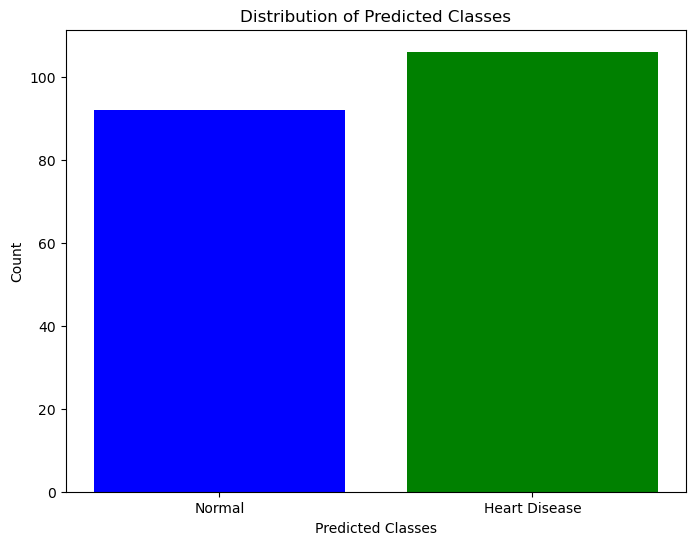

In [24]:
# Assuming 'y_pred' contains the predicted labels (0 for 'Normal', 1 for 'Heart Disease')
# You can adjust the labels as needed
predicted_labels = ['Normal' if pred == 0 else 'Heart Disease' for pred in test_y_pred]

# Count the occurrences of each class
label_counts = {label: predicted_labels.count(label) for label in set(predicted_labels)}

# Extract the class labels and their corresponding counts
classes = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['blue', 'green'])  # Adjust colors as needed
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.title('Distribution of Predicted Classes')
plt.show()

In [18]:
predictions_df = pd.DataFrame({
    'PatientID': test_data['PatientID'],
    'HeartDisease': test_y_pred
})
predictions_df.to_csv("test_y_pred.csv", index=False)
